In [1]:
import pandas as pd
import numpy as np
import math
from math import sqrt
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas import Series
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['font.family'] = 'Times New Roman'
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time #helper libraries

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True)

In [2]:
#Baca data DMI NOAA
df =  pd.read_excel('Data IOD.xlsx')# Set 'Date' as the index

# Konversi kolom 'Tanggal' ke format datetime jika belum
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce') # Konversi ke datetime

df.set_index('Tanggal', inplace=True)  # Atur kolom tanggal sebagai indeks

In [3]:
df

,Nilai IOD
Tanggal,
2008-08-03,0.06
2008-08-10,0.10
2008-08-17,0.19
2008-08-24,-0.02
2008-08-31,-0.07
...,...
2024-09-22,-0.48
2024-09-29,-0.43
2024-10-06,-0.38


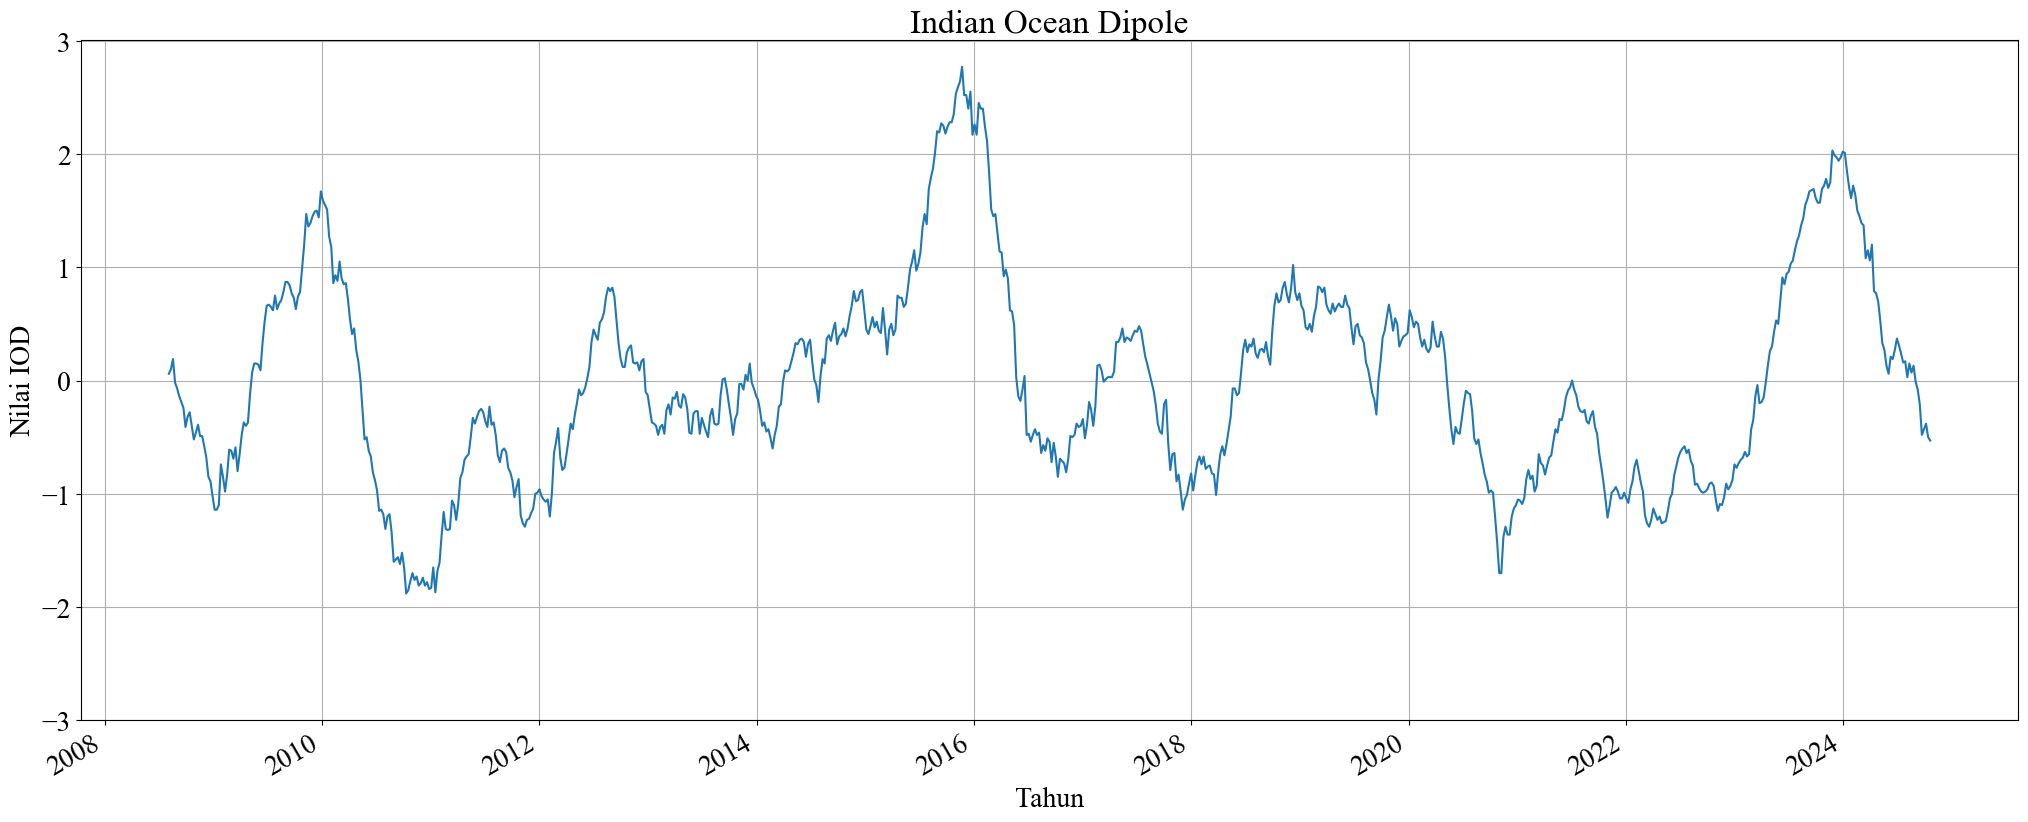

In [4]:
# Plot DMI
df['Nilai IOD'].plot(figsize=(25, 10))
plt.title('Indian Ocean Dipole')
plt.ylabel('Nilai IOD')
plt.xlabel('Tahun')
plt.yticks(np.arange(-3, 4, 1))  # Set y-axis ticks from -3 to 3 with interval 1
plt.grid()
plt.show()

In [5]:
# Split Data Training dan Testing
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

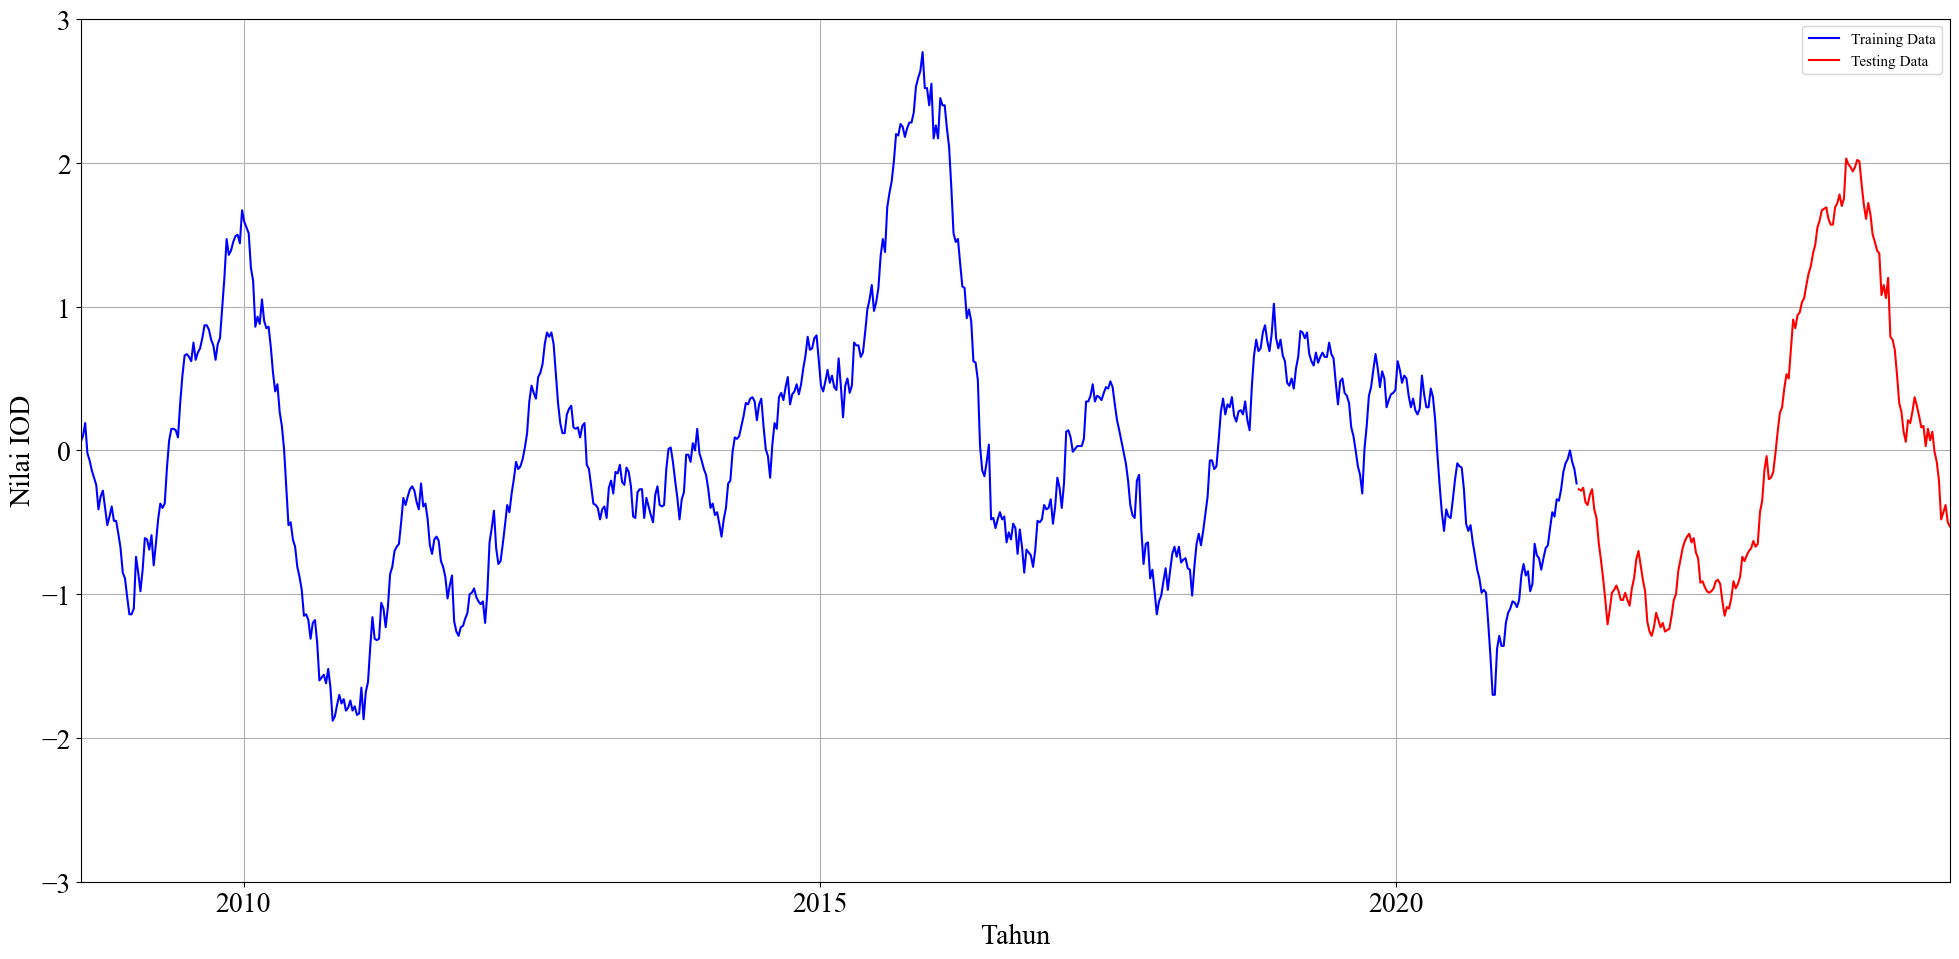

In [6]:
# Plot the training and testing data on the same graph
plt.figure(figsize=(20, 10))
plt.plot(train.index, train['Nilai IOD'], color='blue', label='Training Data')
plt.plot(test.index, test['Nilai IOD'], color='red', label='Testing Data')
plt.ylabel('Nilai IOD')
plt.xlabel('Tahun')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))
plt.xlim([pd.Timestamp('2008-08-03'), pd.Timestamp('2024-10-20')])
plt.yticks(np.arange(-3, 4, 1)) 
plt.legend(fontsize=11, loc='upper right')
plt.grid()
plt.tight_layout()
# save_path = 'D:\\SKRIPSI\\Draft Skripsi\\Hasil\\lstm\\IOD\\plot_setdata.png'
# plt.savefig(save_path)
plt.show()

In [7]:
# Print the split data values
print("Training Data Size:", len(train))
print("Testing Data Size:", len(test))
print("\nTraining Data Sample:")
print(train.head())
print("\nTesting Data Sample:")
print(test.head())

Training Data Size: 676
Testing Data Size: 169

Training Data Sample:
            Nilai IOD
Tanggal              
2008-08-03       0.06
2008-08-10       0.10
2008-08-17       0.19
2008-08-24      -0.02
2008-08-31      -0.07

Testing Data Sample:
            Nilai IOD
Tanggal              
2021-08-01      -0.27
2021-08-08      -0.28
2021-08-15      -0.26
2021-08-22      -0.36
2021-08-29      -0.38


In [8]:
# set random seed
tf.random.set_seed(7)

#Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))  
all_y = df['Nilai IOD'].values.reshape(-1, 1) #mengubah array menjadi 2D dg 1 kolom 
dataset = scaler.fit_transform(all_y) #menerapkan scaler yg telah dibuat sebelumnya

# Membuat DataFrame baru dengan data yang telah dinormalisasi
df_normalized = pd.DataFrame(dataset, columns=['Normalisasi_IOD'], index=df.index)

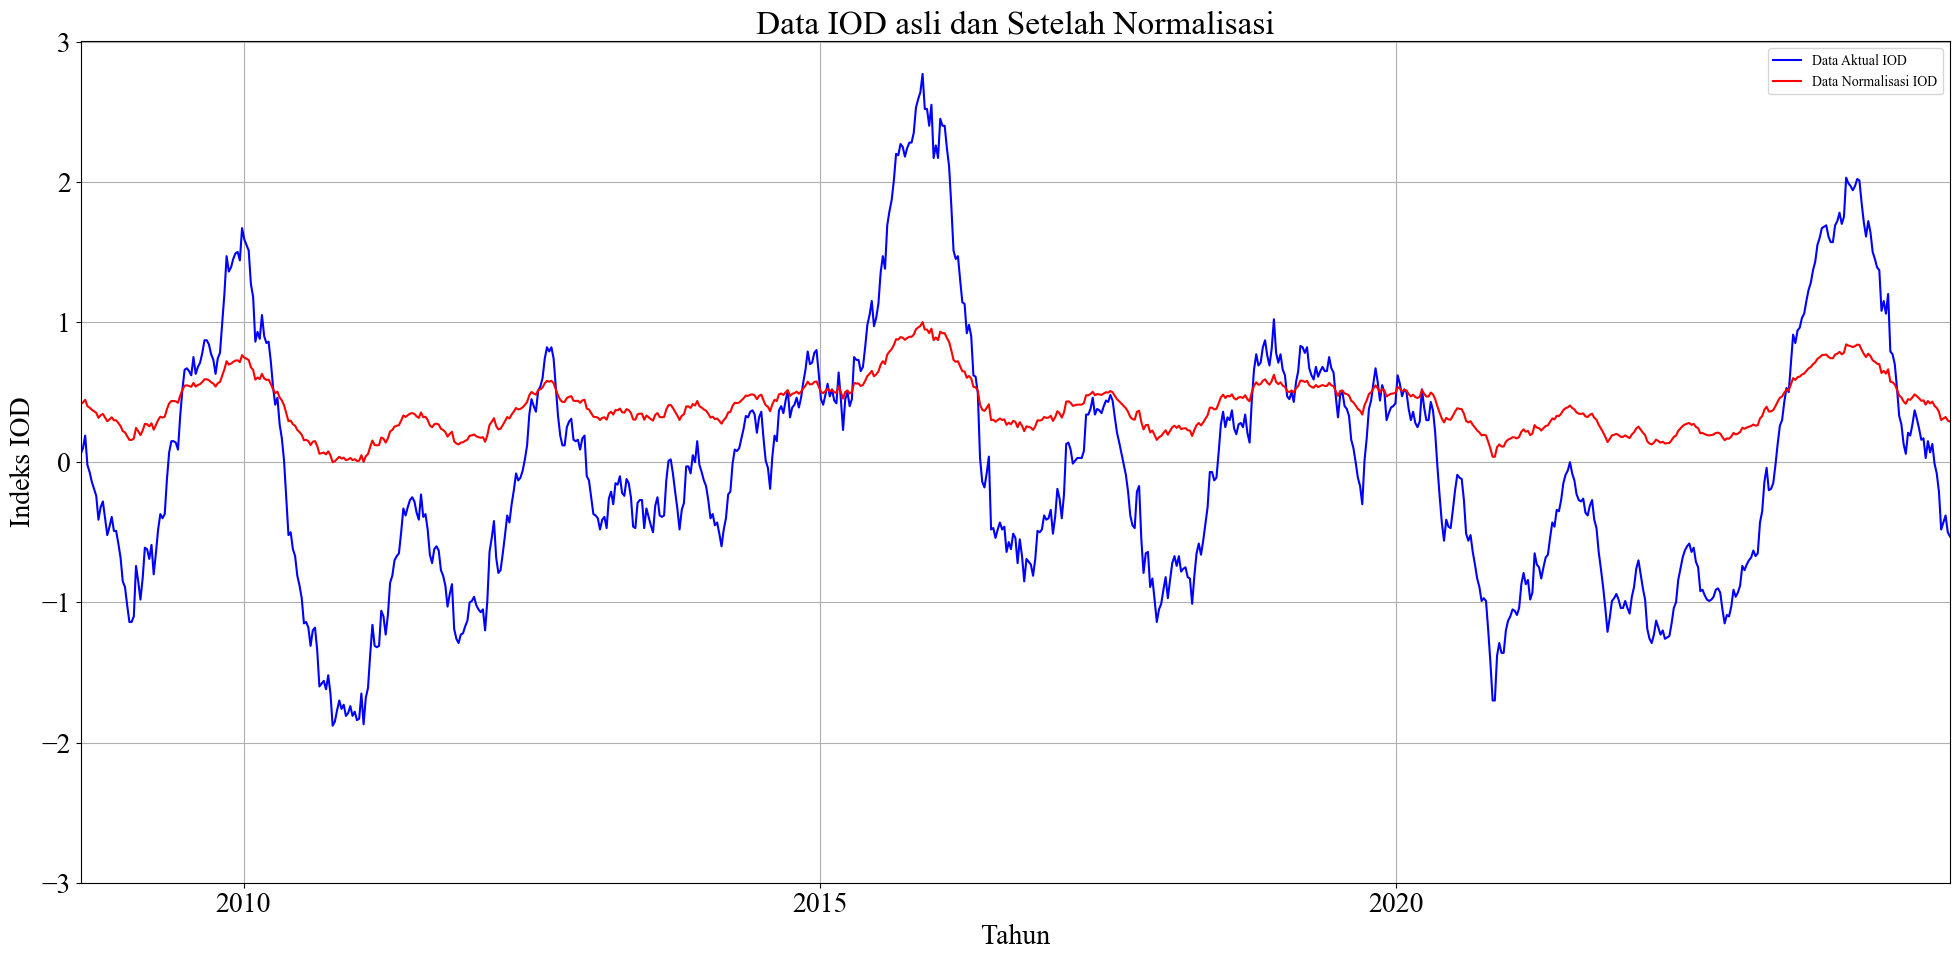

In [9]:
# Plot Data Asli dan Data yang Sudah Dinormalisasi
plt.figure(figsize=(20, 10))
plt.plot(df.index, df['Nilai IOD'], label='Data Aktual IOD', color='blue')
plt.plot(df_normalized.index, df_normalized['Normalisasi_IOD'], label='Data Normalisasi IOD', color='red')

# Save normalized data to Excel
# excel_save_path = 'normalized_data_IOD.xlsx'
# df_normalized.to_excel(excel_save_path, index=True)
# print(f"Normalized data saved to {excel_save_path}")

plt.title('Data IOD asli dan Setelah Normalisasi')
plt.xlabel('Tahun')
plt.ylabel('Indeks IOD')

# Set x-axis format and limits
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format x-axis to show only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))  # Ensure ticks are placed at every 5-year interval
plt.xlim([pd.Timestamp('2008-08-03'), pd.Timestamp('2024-10-20')])  # Set x-axis limits
plt.yticks(np.arange(-3, 4, 1))  # Set y-axis ticks from -3 to 3 with interval 1
plt.legend(fontsize=10, loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()

# save_path = 'D:\\SKRIPSI\\draft skripsi\\Hasil\\lstm\\IOD\\normalisasi.png'
# plt.savefig(save_path)

In [10]:
# pembagian data training dan testing
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
# Supervised Learning
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

optimizer = Adam(learning_rate=0.001)
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(1, look_back)))  # Corrected the placement of activation parameter
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=1, shuffle=False, validation_split=0.2)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.1563 - val_loss: 0.0913
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0703 - val_loss: 0.0125
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0265 - val_loss: 0.0151
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0236 - val_loss: 0.0104
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183 - val_loss: 0.0103
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0169 - val_loss: 0.0078
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0128 - val_loss: 0.0062
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100 - val_loss: 0.0043
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 

In [13]:
# Ambil nilai loss pelatihan dan validasi dari riwayat pelatihan
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

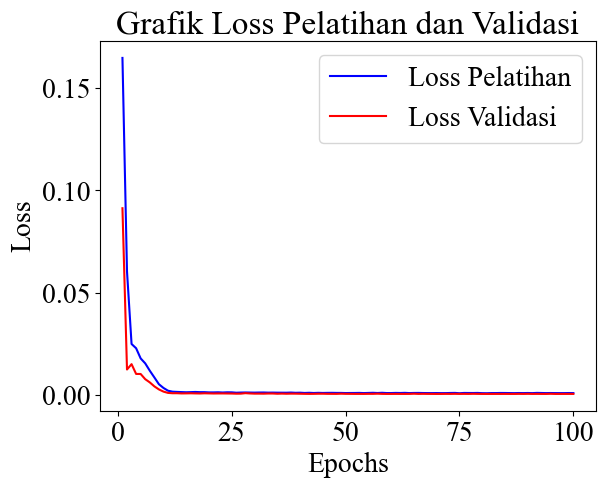

In [14]:
# Plot grafik loss pelatihan dan validasi
plt.plot(epochs, train_loss, 'b', label='Loss Pelatihan')
plt.plot(epochs, val_loss, 'r', label='Loss Validasi')
plt.title('Grafik Loss Pelatihan dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# save_path = 'D:\\SKRIPSI\\draft skripsi\\Hasil\\lstm\\IOD\\loss_IOD.png'
# plt.savefig(save_path)

In [15]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Denormalisasi
train_predict_orig = scaler.inverse_transform(trainPredict)
y_train_orig = scaler.inverse_transform(train.reshape(-1, 1))  # Reshape to 2D array

# Inverse transform for test data
test_predict_orig = scaler.inverse_transform(testPredict)
y_test_orig = scaler.inverse_transform(test.reshape(-1, 1))  # Reshape to 2D array

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


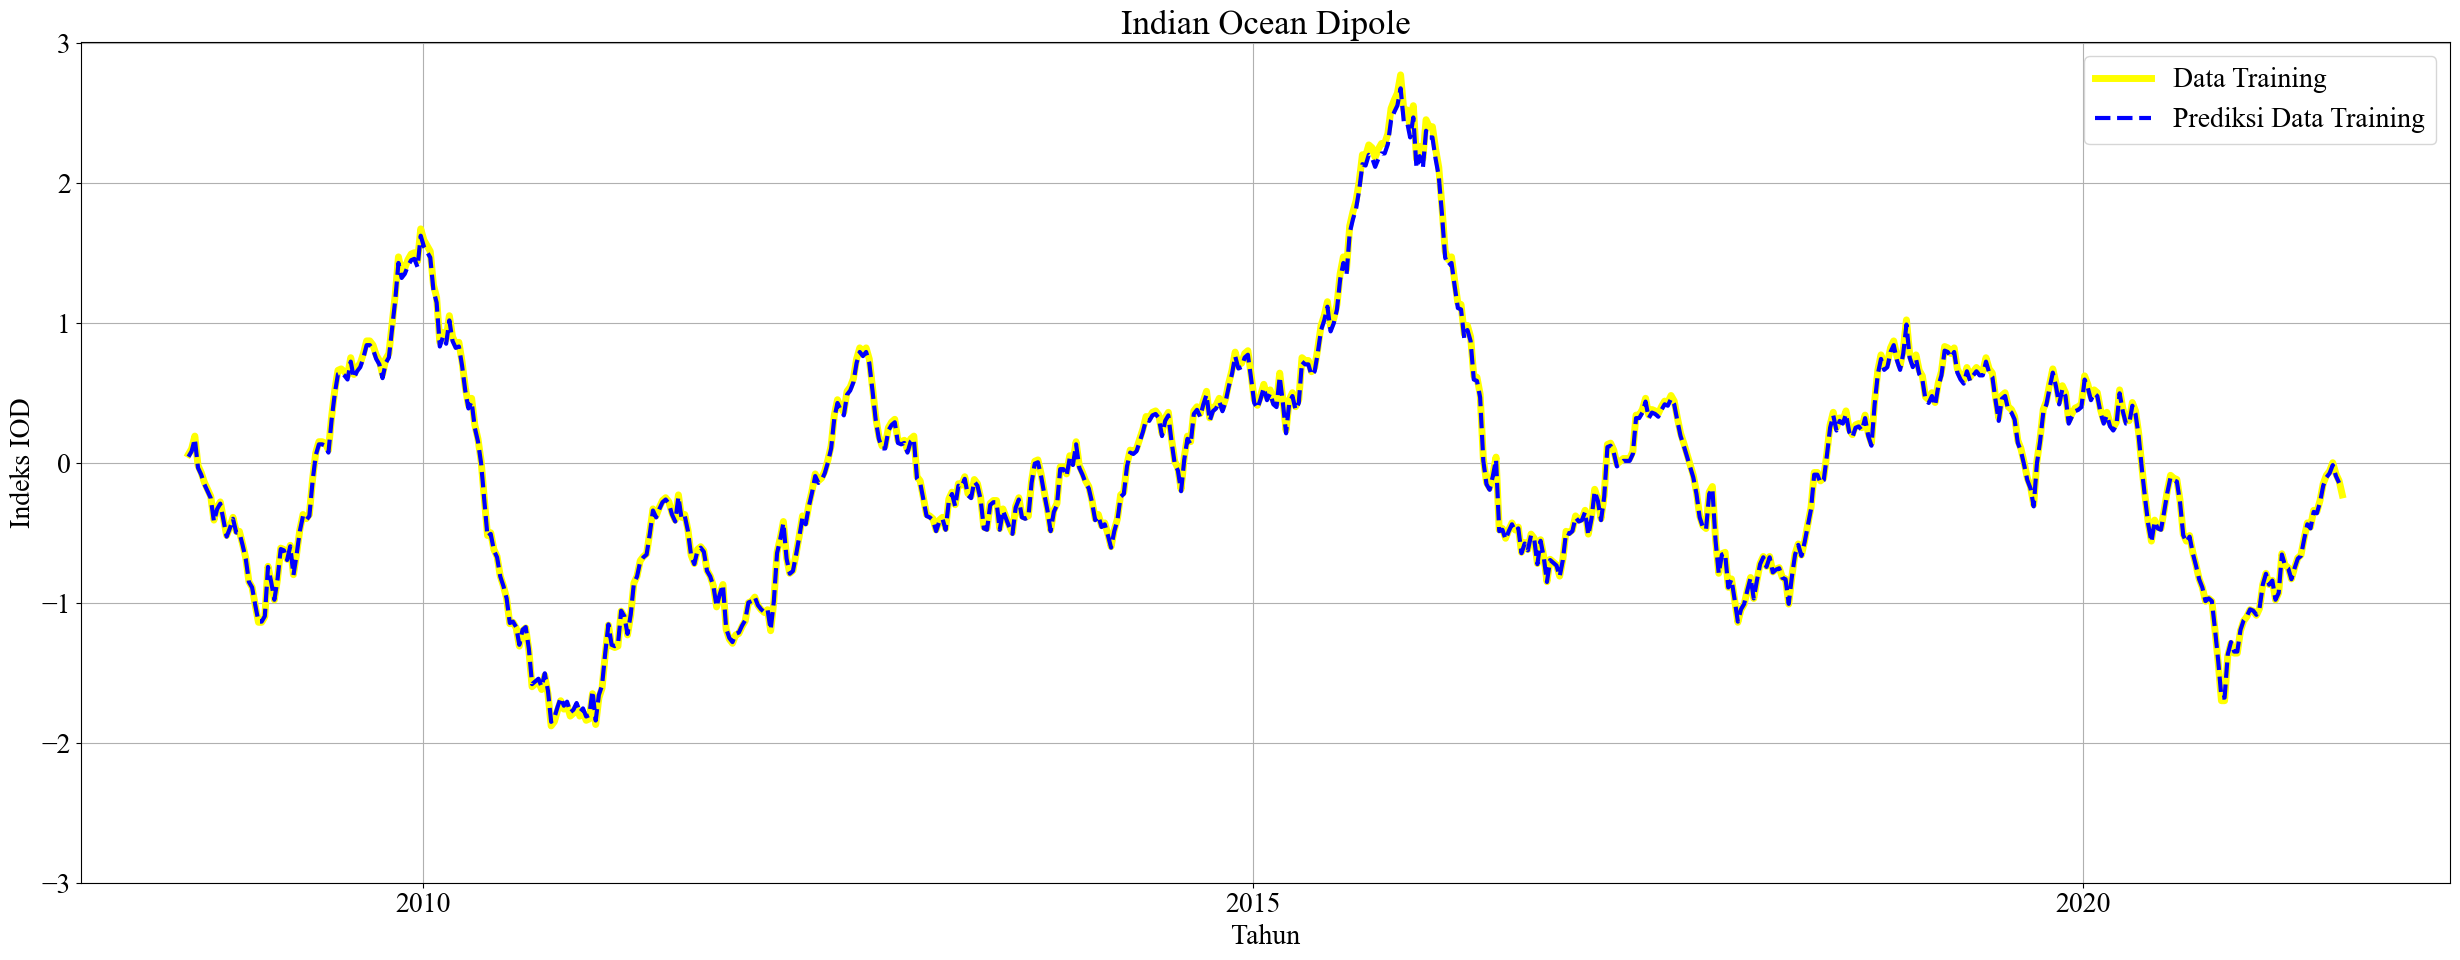

In [16]:
# Plot predictions for training data
plt.figure(figsize=(25, 10))
# plt.subplot(1, 2, 1)
plt.plot(df.index[:len(y_train_orig.flatten())], y_train_orig.flatten(), label='Data Training', lw='5', color='yellow')
plt.plot(df.index[:len(train_predict_orig.flatten())], train_predict_orig.flatten(), label='Prediksi Data Training', lw='3', color='blue', linestyle='--')
plt.title('Indian Ocean Dipole', fontsize=25)
plt.xlabel('Tahun', fontsize=20)
plt.ylabel('Indeks IOD', fontsize=20)

# Set x-axis format and limits
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))
plt.yticks(np.arange(-3, 4, 1))
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

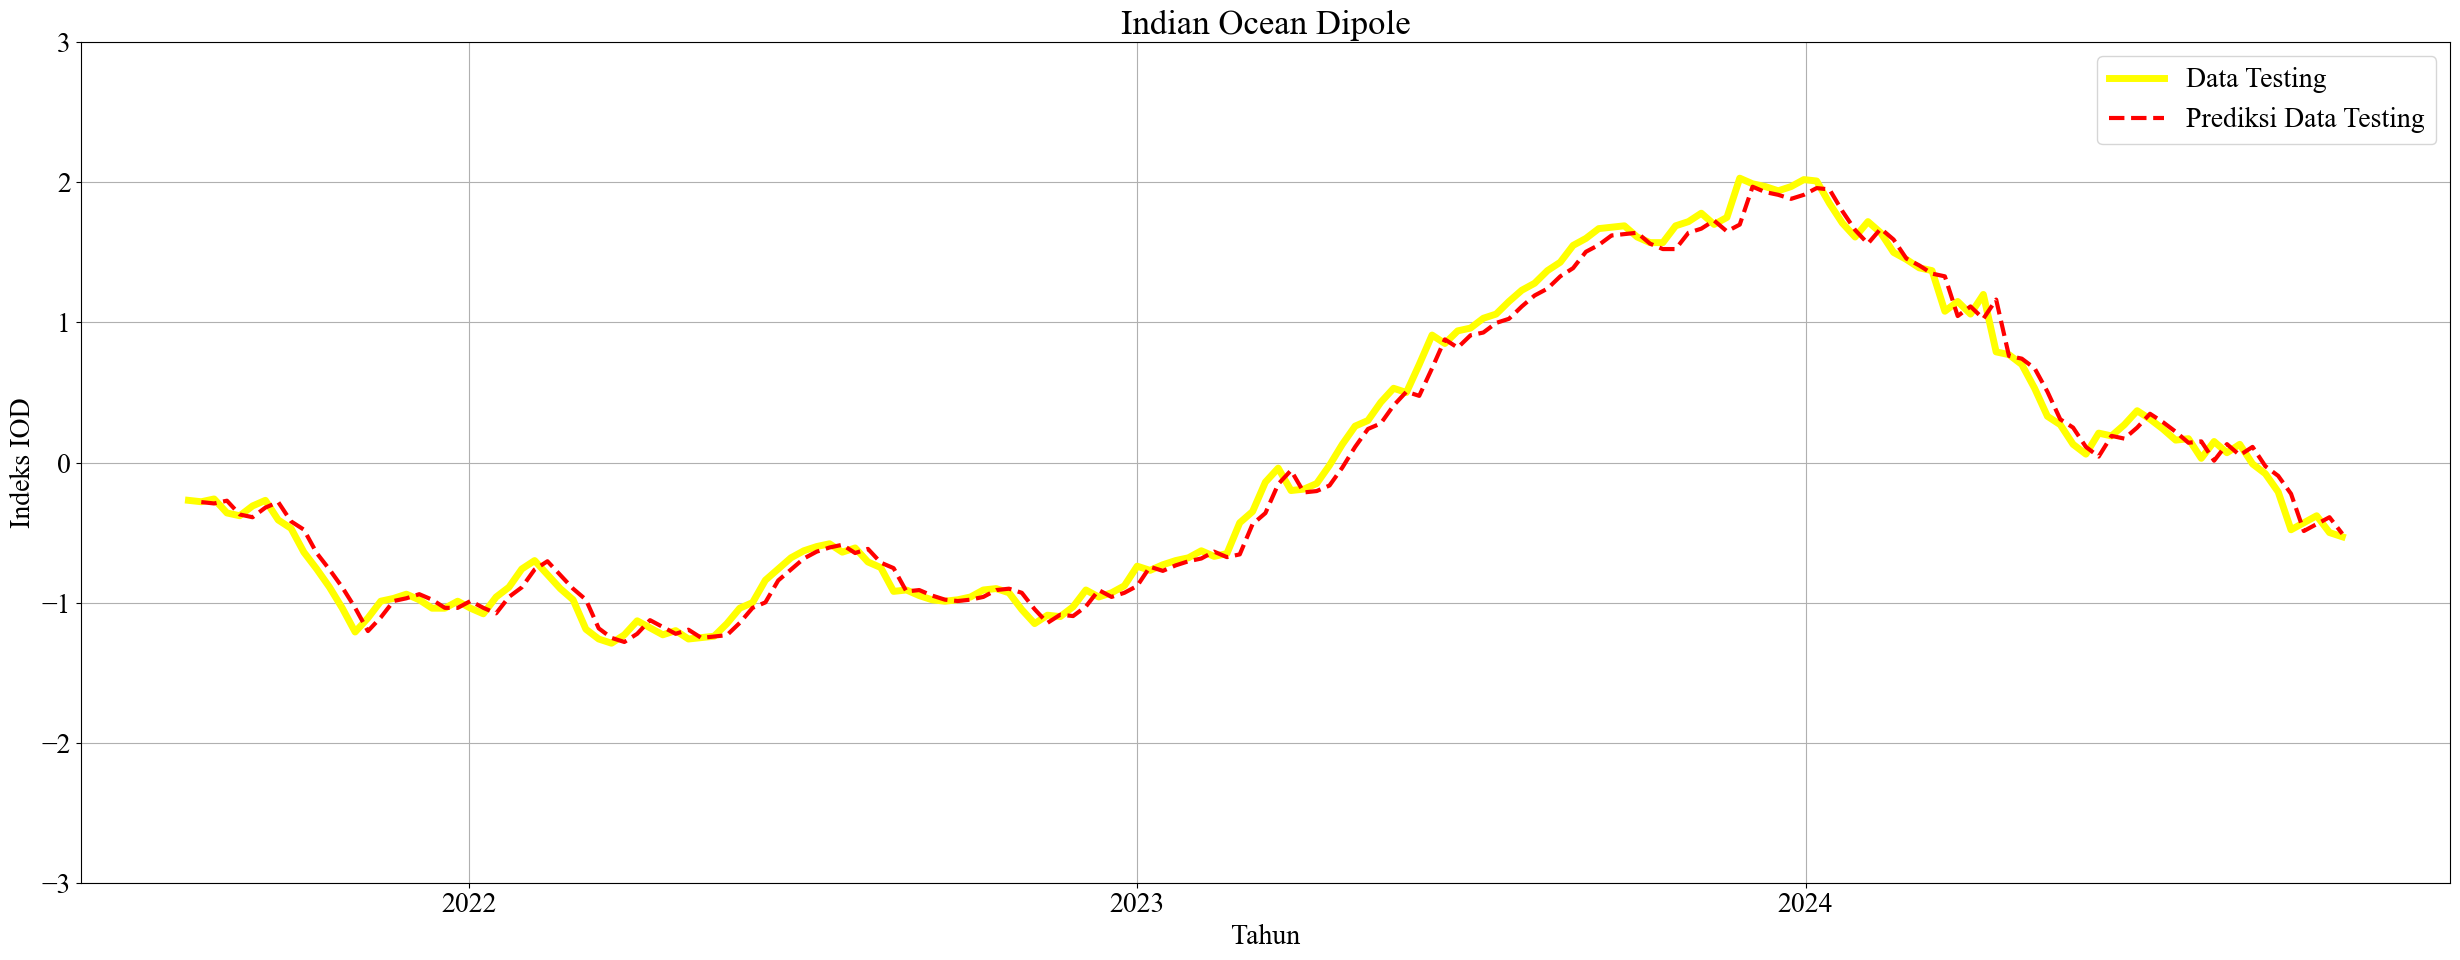

In [17]:
# Plot predictions for test data
plt.figure(figsize=(25, 10))
# plt.subplot(1, 2, 2)

# Use correct indices for the test data
plt.plot(df.index[-len(y_test_orig.flatten()):], y_test_orig.flatten(), label='Data Testing', lw='5', color='yellow')
plt.plot(df.index[-len(test_predict_orig.flatten()):], test_predict_orig.flatten(), label='Prediksi Data Testing', lw='3', color='red', linestyle='--')
plt.title('Indian Ocean Dipole', fontsize=25)
plt.xlabel('Tahun', fontsize=20)
plt.ylabel('Indeks IOD', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format x-axis to show only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))  # Ensure ticks are placed at every 5-year interval
plt.yticks(np.arange(-3, 4, 1))  # Set y-axis ticks from -3 to 3 with interval 1
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# save_path = 'D:\\SKRIPSI\\draft skripsi\\Hasil\\lstm\\IOD\\uji_train_test.png'
# plt.savefig(save_path)

In [18]:
# Calculate metrics for train data
r2_train = r2_score(y_train_orig[:len(train_predict_orig)], train_predict_orig)
mae_train = mean_absolute_error(y_train_orig[:len(train_predict_orig)], train_predict_orig)
mse_train = mean_squared_error(y_train_orig[:len(train_predict_orig)], train_predict_orig)
rmse_train = np.sqrt(mse_train)

# Calculate metrics for test data
# Ensure that the indices for test data are correctly selected
r2_test = r2_score(y_test_orig[-len(test_predict_orig):], test_predict_orig)
mae_test = mean_absolute_error(y_test_orig[-len(test_predict_orig):], test_predict_orig)
mse_test = mean_squared_error(y_test_orig[-len(test_predict_orig):], test_predict_orig)
rmse_test = np.sqrt(mse_test)

# Display metrics in a DataFrame
metrics_data = {
    'Metric': ['R\N{SUPERSCRIPT TWO}', 'MAE', 'MSE', 'RMSE'],
    'Train Data': [r2_train, mae_train, mse_train, rmse_train],
    'Test Data': [r2_test, mae_test, mse_test, rmse_test]}

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.round(4)

print(metrics_df)

  Metric  Train Data  Test Data
0     R²      0.9992     0.9899
1    MAE      0.0189     0.0825
2    MSE      0.0006     0.0108
3   RMSE      0.0241     0.1038


In [19]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
start_index = len(trainPredict) + look_back  # Adjusted start index
end_index = start_index + len(testPredict)  # Adjusted end index
testPredictPlot[start_index:end_index, :] = testPredict  # Corrected assignment

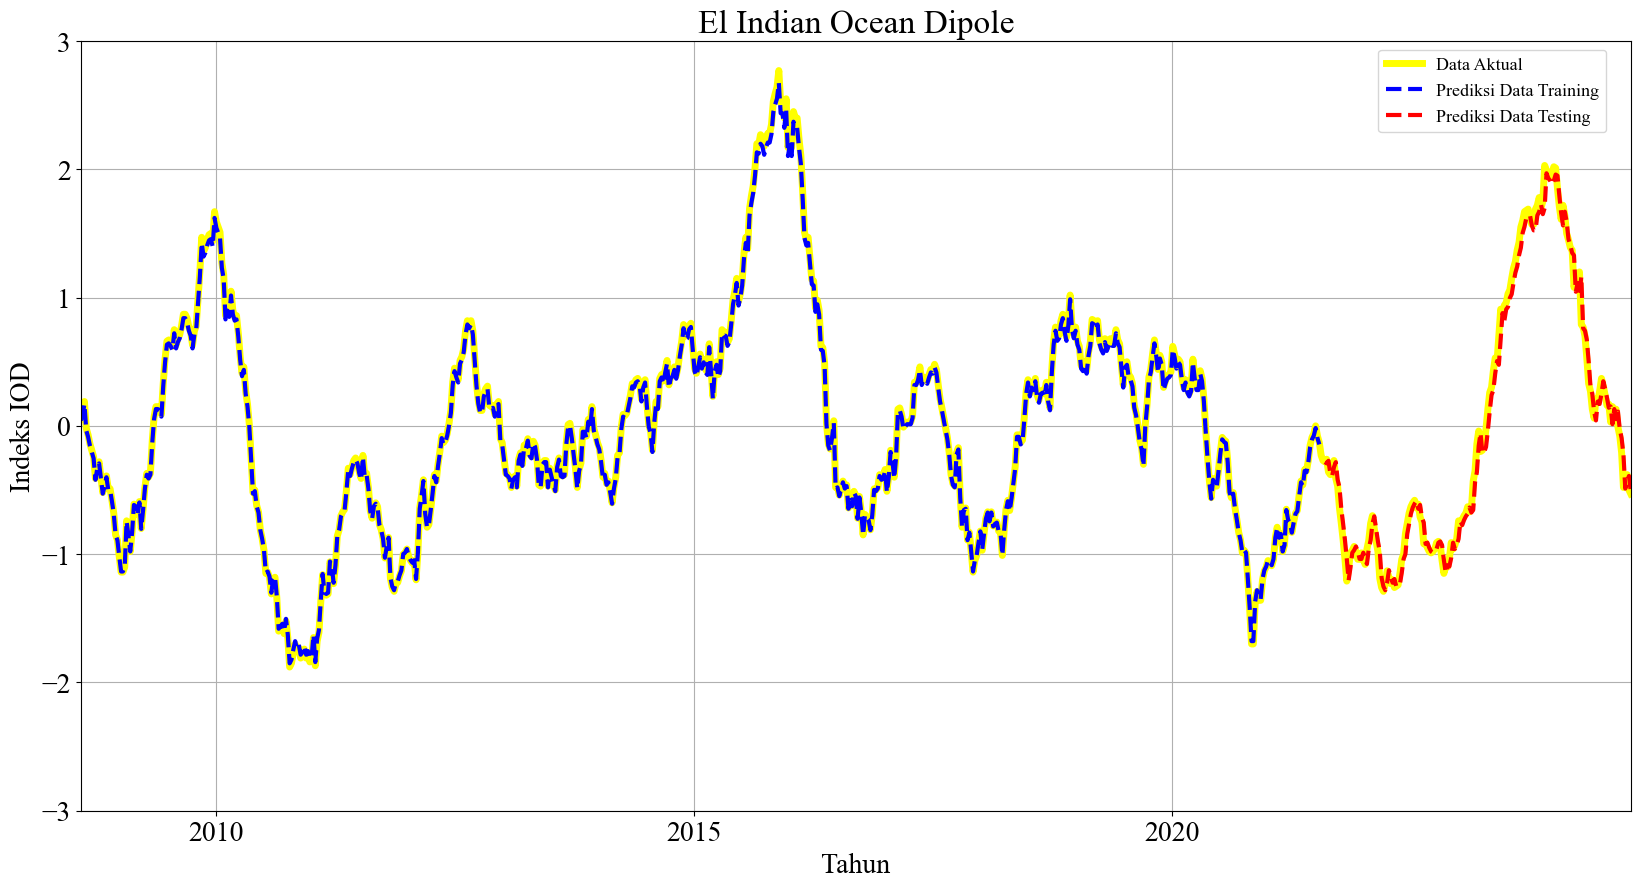

In [20]:
# plot baseline and predictions
plt.figure(figsize=(20, 10))
plt.plot(df.index, scaler.inverse_transform(dataset), label='Data Aktual', lw='5', color='yellow')
plt.plot(df.index[:len(train_predict_orig.flatten())], train_predict_orig.flatten(), label='Prediksi Data Training', lw='3', color='blue', linestyle='--')
plt.plot(df.index[-len(test_predict_orig.flatten()):], test_predict_orig.flatten(), label='Prediksi Data Testing', lw='3', color='red', linestyle='--')
plt.title('El Indian Ocean Dipole')
plt.xlabel('Tahun')
plt.ylabel('Indeks IOD')
plt.legend(fontsize=13, loc='upper right', bbox_to_anchor=(0.99, 1))

# Set x-axis format and limits
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format x-axis to show only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))  # Ensure ticks are placed at every 5-year interval
plt.xlim([pd.Timestamp('2008-08-03'), pd.Timestamp('2024-10-20')])  # Set x-axis limits
plt.yticks(np.arange(-3, 4, 1))  # Set y-axis ticks from -3 to 3 with interval 1

plt.grid()
plt.show()

# save_path = 'D:\\SKRIPSI\\draft skripsi\\Hasil\\lstm\\IOD\\prediksi_IOD.png'
# plt.savefig(save_path)

In [ ]:
# Create dataframes for actual and predicted values
train_results = pd.DataFrame({'Date': df.index[:len(train_predict_orig)],
                              'Actual Training': y_train_orig[:len(train_predict_orig):].flatten(),
                              'Predicted Training': train_predict_orig.flatten()})

test_results = pd.DataFrame({'Date': df.index[-len(test_predict_orig):],
                             'Actual Testing': y_test_orig[-len(test_predict_orig):].flatten(),
                             'Predicted Testing': test_predict_orig.flatten()})

# Print the dataframes
print("Training Results:")
print(train_results)

print("\nTesting Results:")
print(test_results)

# Simpan DataFrame ke file Excel
# with pd.ExcelWriter('D:\\SKRIPSI\\draft skripsi\\Hasil\\lstm\\IOD\\prediksi_lstm.xlsx') as writer:
#    train_results.to_excel(writer, sheet_name='Training Results', index=False)
#    test_results.to_excel(writer, sheet_name='Testing Results', index=False)

Training Results:
          Date  Actual Training  Predicted Training
0   2008-08-03             0.06            0.042604
1   2008-08-10             0.10            0.082014
2   2008-08-17             0.19            0.170688
3   2008-08-24            -0.02           -0.036209
4   2008-08-31            -0.07           -0.085461
..         ...              ...                 ...
670 2021-06-20            -0.09           -0.105160
671 2021-06-27            -0.06           -0.075611
672 2021-07-04             0.00           -0.016507
673 2021-07-11            -0.08           -0.095311
674 2021-07-18            -0.13           -0.144554

[675 rows x 3 columns]

Testing Results:
          Date  Actual Testing  Predicted Testing
0   2021-08-08           -0.28          -0.282384
1   2021-08-15           -0.26          -0.292225
2   2021-08-22           -0.36          -0.272542
3   2021-08-29           -0.38          -0.370935
4   2021-09-05           -0.31          -0.390606
..         ...  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Hasil Prediksi dengan Confidence Interval:
      Tanggal  Prediksi  Confidence Lower  Confidence Upper
0  2024-12-01 -0.538046         -0.595420         -0.480672
1  2025-01-01 -0.545950         -0.603324         -0.488575
2  2025-02-01 -0.553713         -0.611087         -0.496339
3  2025-03-01 -0.561337         -0.618711         -0.503963
4  2025-04-01 -0.568825         -0.626199         -0.511451
5  2025-05-01 -0.576178         -0.633552         -0.518804
6  2025-06-01 -0.583399         -0.640773         -0.526024
7  2025-07-01 -0.59

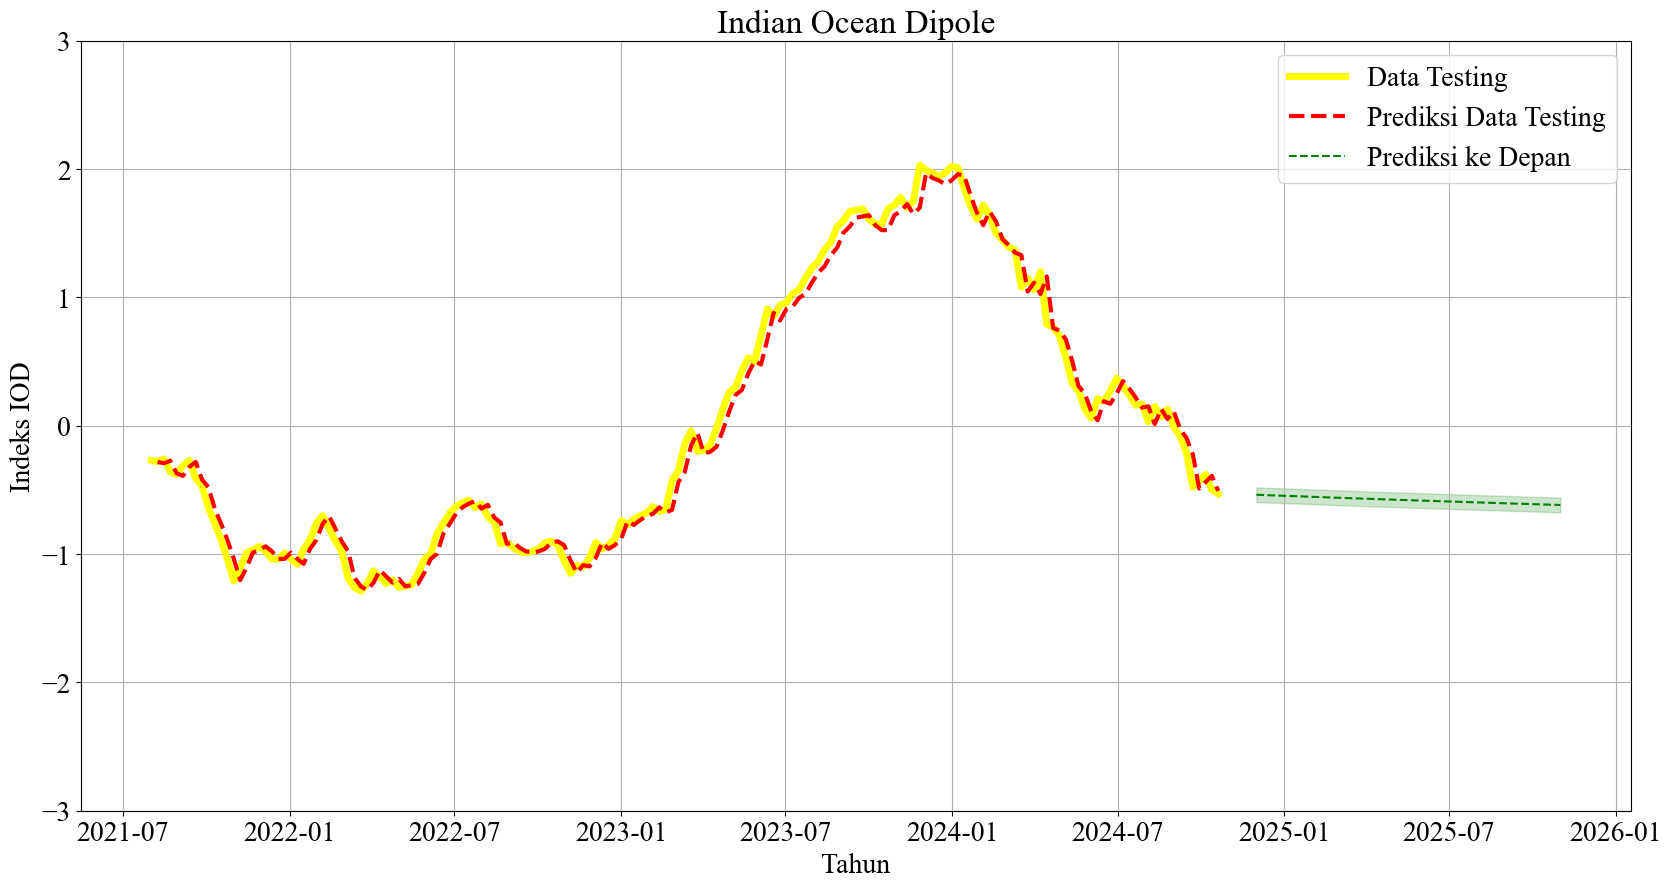

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import scipy.stats

# Assuming necessary modules like model, scaler, dataset, df, etc. are already defined

# Parameters
future_steps = 12  # Number of months to predict into the future

# Take the last point of the dataset for prediction input
last_point = dataset[-1:]
future_input = np.array([last_point])
# future_input_reshaped = np.reshape(last_point, (1, 1, last_point.shape[1]))

# Reshape future_input to 3D array (samples, time steps, features)
future_input_reshaped = np.reshape(future_input, (future_input.shape[0], 1, future_input.shape[1]))

# Use the model to predict future values
future_predictions_normalized = []

for i in range(future_steps):
    # Predict one step ahead
    prediction_normalized = model.predict(future_input_reshaped)
    
    # Append the prediction
    future_predictions_normalized.append(prediction_normalized[0, 0])
    
    # Update the input for the next prediction step
    future_input = np.array([[prediction_normalized[0]]])
    future_input_reshaped = np.reshape(future_input, (future_input.shape[0], 1, future_input.shape[1]))

# Inverse transform predictions to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions_normalized).reshape(-1, 1))

# Define future time axis
extended_time_axis = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# Calculate confidence interval
confidence_level = 0.95
prediction_std = np.std(future_predictions, ddof=1)
margin_of_error = prediction_std * scipy.stats.t.ppf((1 + confidence_level) / 2, len(future_predictions) - 1)
lower_bound = future_predictions - margin_of_error
upper_bound = future_predictions + margin_of_error

# Create DataFrame for future predictions
future_predictions_df = pd.DataFrame({
    'Tanggal': extended_time_axis,
    'Prediksi': future_predictions.flatten(),
    'Confidence Lower': lower_bound.flatten(),
    'Confidence Upper': upper_bound.flatten()})

# Define path for saving the CSV
# csv_save_path = 'D:\\SKRIPSI\\draft skripsi\\Hasil\\lstm\\IOD\\Prediksi_Bulan_IOD.csv'

# Save DataFrame to Excel and CSV
# future_predictions_df.to_excel('D:\\SKRIPSI\\draft skripsi\\Hasil\\lstm\\IOD\\Prediksi_Bulan_IOD.xlsx', index=False)
# future_predictions_df.to_csv(csv_save_path, index=False)

print("\nHasil Prediksi dengan Confidence Interval:")
print(future_predictions_df)

# Plot the results
plt.figure(figsize=(20, 10))

# Plot actual and predicted values
plt.plot(df.index[-len(y_test_orig.flatten()):], y_test_orig.flatten(), label='Data Testing', lw='5', color='yellow')
plt.plot(df.index[-len(test_predict_orig.flatten()):], test_predict_orig.flatten(), label='Prediksi Data Testing', lw='3', color='red', linestyle='--')
plt.plot(extended_time_axis, future_predictions, label='Prediksi ke Depan', linestyle='--', color='green')
plt.fill_between(extended_time_axis, lower_bound.flatten(), upper_bound.flatten(), color='green', alpha=0.2)
plt.title('Indian Ocean Dipole')
plt.xlabel('Tahun')
plt.ylabel('Indeks IOD')
plt.yticks(np.arange(-3, 4, 1)) 
plt.legend()
plt.grid()
plt.show()

# Assuming df.index contains datetime values
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps, freq='M')

# Save the plot
# save_path = 'D:\\SKRIPSI\\draft skripsi\\Hasil\\lstm\\IOD\\plot_prediksibulan_IOD.png'
# plt.savefig(save_path) 

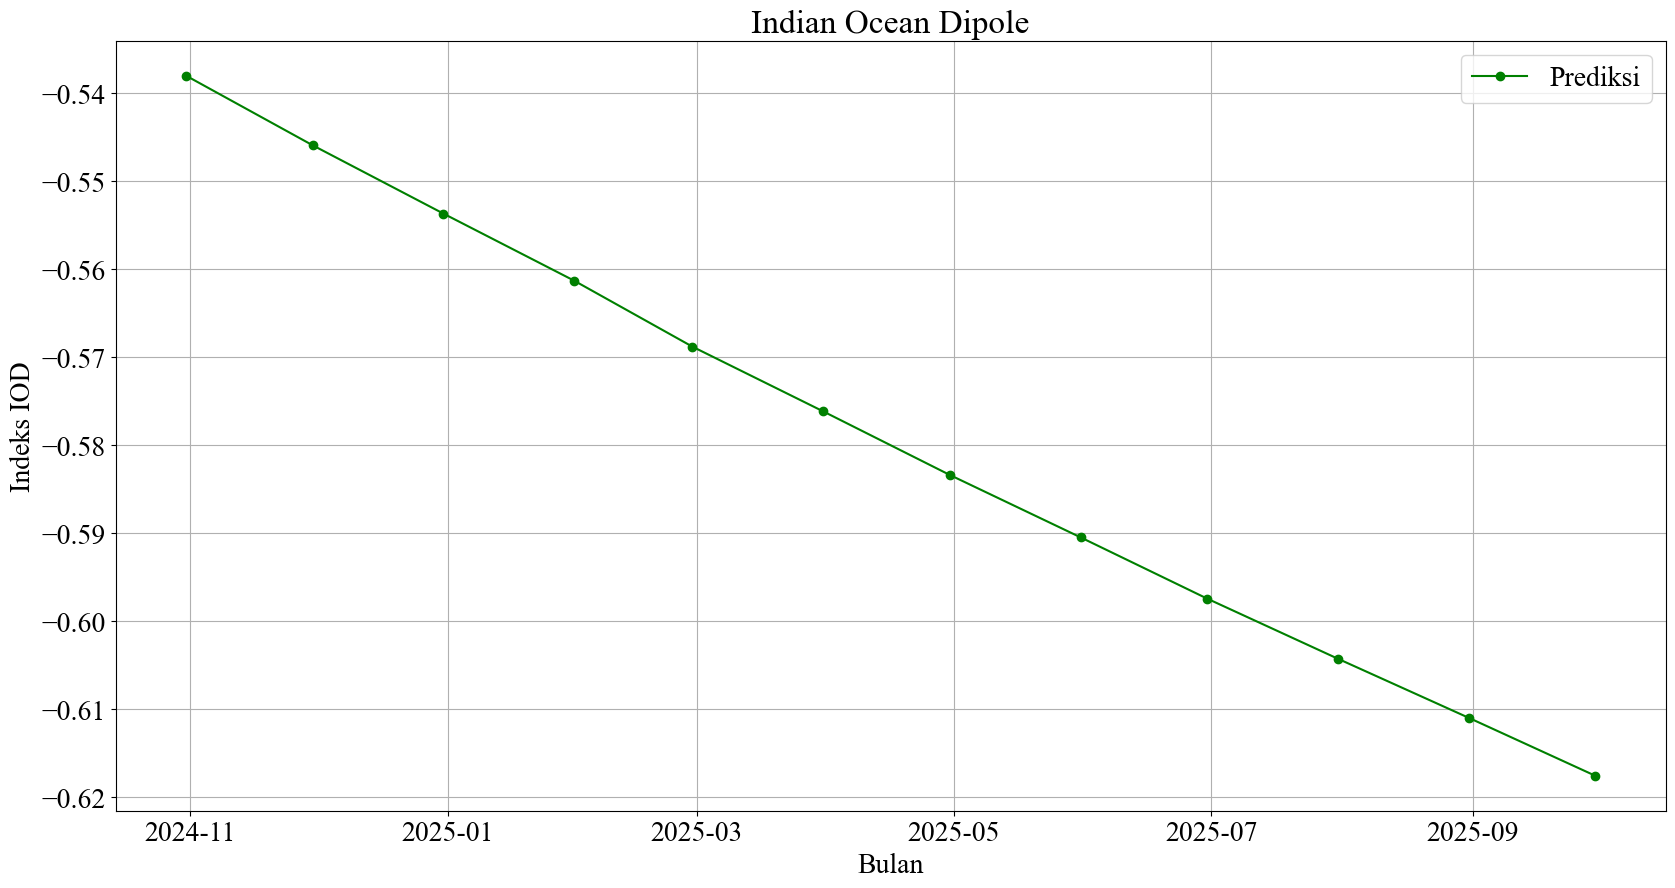

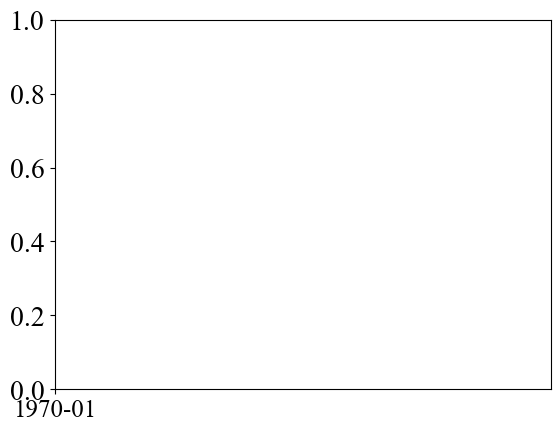

In [23]:
# Plot future predictions as a line with extended time axis
plt.figure(figsize=(20, 10))
plt.plot(future_dates, future_predictions, label='Prediksi', linestyle='-', marker='o', color='green')
plt.title('Indian Ocean Dipole')
plt.xlabel('Bulan')
plt.ylabel('Indeks IOD')
plt.legend()
plt.grid()
plt.show()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().tick_params(axis='x', labelsize=18)

# save_path = 'D:\\SKRIPSI\\draft skripsi\\Hasil\\lstm\\IOD\\prediksi_bulan.png'
# plt.savefig(save_path)

In [24]:
LSTM_Result = pd.DataFrame(columns=['IOD', 'predicted', 'residuals'])
LSTM_Result['IOD'] = df['Nilai IOD']
LSTM_Result['predicted'] = LSTM_Result['Prediksi']
LSTM_Result['residuals'] = LSTM_Result['IOD'] - LSTM_Result['predicted']
# LSTM_Result.to_excel('IOD_prediksi_residual_lstm.xlsx')
LSTM_Result

KeyError: 'Prediksi'

In [ ]:
import numpy as np

# Drop rows with NaN values
LSTM_Result = LSTM_Result.dropna(subset=['IOD', 'predicted'])

# Replace 0 with NaN
LSTM_Result.replace(0, np.nan, inplace=True)

# Plotting hasil prediksi bersama dengan data aktual
plt.figure(figsize=(15, 6))
plt.plot(LSTM_Result['IOD'], label='Data Aktual', color='blue', lw=5)
plt.plot(LSTM_Result['predicted'], label='Prediksi', color='red', linestyle='dashed', lw=3)
plt.title('Prediksi IOD dengan Model LSTM', fontsize=25)
plt.xlabel('Tahun', fontsize=20)
plt.ylabel('Indeks IOD', fontsize=20)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format x-axis to show only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))  # Ensure ticks are placed at every 5-year interval
plt.xlim([pd.Timestamp('1981-01-01'), pd.Timestamp('2023-12-31')])  # Set x-axis limits
plt.yticks(np.arange(-3, 4, 1))  # Set y-axis ticks from -3 to 3 with interval 1
plt.legend()
plt.grid()

# Save the plot
# save_path = 'D:\\SKRIPSI\\draft skripsi\\Hasil\\lstm\\IOD\\lstm_IOD.png'
# plt.savefig(save_path)

In [ ]:
# Drop rows with NaN values again
LSTM_Result = LSTM_Result.dropna(subset=['IOD', 'predicted'])

# Menghitung metrik kesalahan untuk data uji
r_squared = r2_score(LSTM_Result['IOD'], LSTM_Result['predicted'])
mae = mean_absolute_error(LSTM_Result['IOD'], LSTM_Result['predicted'])
mse = mean_squared_error(LSTM_Result['IOD'], LSTM_Result['predicted'])
rmse = sqrt(mean_squared_error(LSTM_Result['IOD'], LSTM_Result['predicted']))

# Membuat dataframe
evaluation_df = pd.DataFrame({
    'Metric': ['R-squared', 'MAE', 'MSE', 'RMSE'],
    'IOD': [r_squared, mae, mse, rmse]
})

# Menampilkan dataframe
print(evaluation_df)